### **Anggota Kelompok:**
* Ahmad Nur Rofik_23.11.5475
* Rizal Anggoro_23.11.5498
* Hanjaya Hartono_23.11.5449
* Fata Salma Putra Pureka_23.11.5470

Install Library

In [ ]:
!pip install pyspark
!pip install wordcloud

import os
from google.colab import drive
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace, when, to_timestamp, length, expr
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.classification import NaiveBayes, LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

Inisialisasi & Load Dataset

In [ ]:
# 1. Inisialisasi Spark
spark = SparkSession.builder \
    .appName("UAS_BigData_Security_Analysis") \
    .config("spark.sql.ansi.enabled", "false") \
    .master("local[*]") \
    .getOrCreate()

# 2. Mount Drive
drive.mount('/content/drive')

# 3. Load Dataset dengan Opsi "MultiLine" (PENTING!)
file_path = "/content/drive/My Drive/ulasan_bca_mobile.csv"

if os.path.exists(file_path):
    print(f"Dataset ditemukan di: {file_path}")
    df = spark.read.option("header", "true") \
                   .option("inferSchema", "true") \
                   .option("quote", "\"") \
                   .option("escape", "\"") \
                   .option("multiLine", "true") \
                   .csv(file_path)
    df.show(5)
else:
    raise Exception("File tidak ditemukan! Mohon upload file ke Google Drive.")

Mounted at /content/drive
Dataset ditemukan di: /content/drive/My Drive/ulasan_bca_mobile.csv
+--------------------+------+-------------------+
|                teks|rating|            tanggal|
+--------------------+------+-------------------+
|         baik sekali|     5|2026-01-22 13:30:08|
|plis jangan pake ...|     1|2026-01-22 13:22:48|
|        sangan bagus|     5|2026-01-22 13:05:14|
|                nice|     5|2026-01-22 12:01:55|
|ini knapa yah say...|     3|2026-01-22 09:16:20|
+--------------------+------+-------------------+
only showing top 5 rows


##Analisis :
Output tersebut menampilkan pratinjau (preview) dari dataset ulasan aplikasi BCA Mobile yang berhasil diakses dari Google Drive. Tabel data memperlihatkan lima baris teratas dengan tiga kolom utama teks, rating, dan tanggal—yang berfungsi untuk memastikan bahwa data telah dimuat dengan benar dan siap untuk tahap analisis selanjutnya.

Preprocessing Data

In [ ]:
# 1. Handling Missing Value
df_clean = df.dropna(subset=["teks", "rating", "tanggal"])

# 2. Safe Casting (REVISI PENTING)
# Gunakan 'try_cast' (lewat expr) agar jika ada teks nyasar, dia jadi null (tidak error)
df_casted = df_clean.withColumn("rating", expr("try_cast(rating as int)")) \
                    .withColumn("tanggal_fix", to_timestamp(col("tanggal"), "yyyy-MM-dd HH:mm:ss"))

# Hapus baris yang gagal di-cast (ratingnya jadi null)
df_casted = df_casted.filter(col("rating").isNotNull())

# 3. Text Cleaning & Labeling
df_final = df_casted.withColumn("clean_text", lower(col("teks"))) \
                    .withColumn("clean_text", regexp_replace("clean_text", "[^a-zA-Z\\s]", "")) \
                    .withColumn("label", when(col("rating") >= 4, 1.0).otherwise(0.0)) \
                    .filter(length(col("clean_text")) > 3)

print("Jumlah data bersih:", df_final.count())
df_final.printSchema()
df_final.select("teks", "rating", "label").show(3, truncate=50)

Jumlah data bersih: 1900
root
 |-- teks: string (nullable = true)
 |-- rating: integer (nullable = true)
 |-- tanggal: timestamp (nullable = true)
 |-- tanggal_fix: timestamp (nullable = true)
 |-- clean_text: string (nullable = true)
 |-- label: double (nullable = false)

+--------------------------------------------------+------+-----+
|                                              teks|rating|label|
+--------------------------------------------------+------+-----+
|                                       baik sekali|     5|  1.0|
|plis jangan pake apk ini. uang sering ilang sen...|     1|  0.0|
|                                      sangan bagus|     5|  1.0|
+--------------------------------------------------+------+-----+
only showing top 3 rows


##Analisis :
Output ini menampilkan hasil dari proses pembersihan dan transformasi data, di mana tersisa 1.900 data bersih dengan struktur skema yang telah diperbarui, termasuk penambahan kolom label dan clean_text. Tabel pratinjau menunjukkan bahwa proses pelabelan sentimen telah berhasil dilakukan, di mana ulasan dengan rating 5 diklasifikasikan sebagai positif (label 1.0) dan ulasan dengan rating 1 diklasifikasikan sebagai negatif (label 0.0), menandakan dataset ini sudah siap untuk tahap pemodelan machine learning.

Exploratory Data Analysis (EDA)

Visualisasi Data (EDA)


/tmp/ipython-input-343797608.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=pdf, palette='viridis')


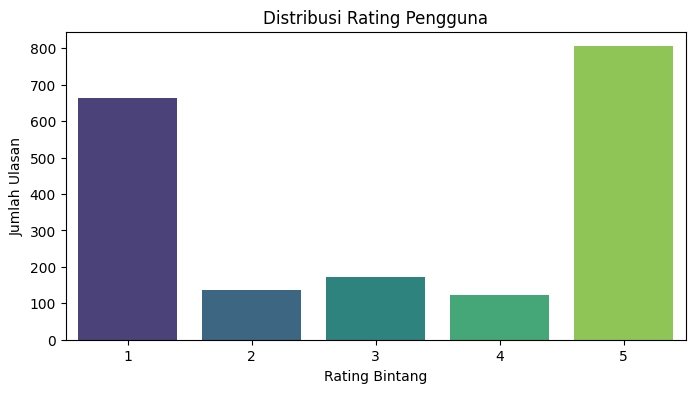

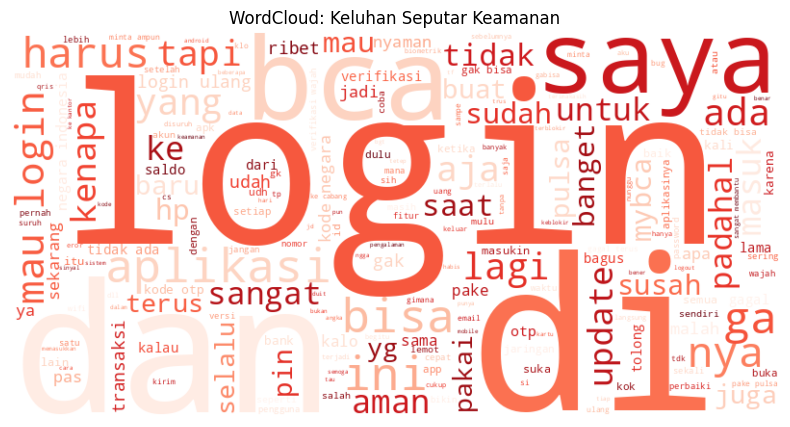

In [ ]:
print("Visualisasi Data (EDA)")

# Konversi ke Pandas (Hanya untuk keperluan plotting)
pdf = df_final.select("rating", "clean_text").toPandas()

# Visualisasi 1: Bar Chart Distribusi Rating
plt.figure(figsize=(8, 4))
sns.countplot(x='rating', data=pdf, palette='viridis')
plt.title('Distribusi Rating Pengguna')
plt.xlabel('Rating Bintang')
plt.ylabel('Jumlah Ulasan')
plt.show()

# Visualisasi 2: WordCloud
security_text = " ".join(pdf[pdf['clean_text'].str.contains('aman|bobol|login|hack', case=False, na=False)]['clean_text'])

if security_text:
    wc = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(security_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('WordCloud: Keluhan Seputar Keamanan')
    plt.show()

##Analisis :


*   Distribusi Rating (Bar Chart): Data menunjukkan pola Bimodal, dimana mayoritas ulasan berkumpul di Rating 1 (Sangat Kecewa) dan Rating 5 (Sangat Puas). Ini menunjukkan polarisasi pendapat yang ekstrem.
*   WordCloud Keamanan: WordCloud menyoroti bahwa sisi negatif/keluhan pengguna sangat berfokus pada kendala teknis, yang terlihat dari besarnya kata "login", "susah", "update", dan "verifikasi".


Manipulasi Data (Spark SQL)

In [ ]:
print("Manipulasi Data: Spark SQL, CTE, & Subquery")

# Buat Temporary View
df_final.createOrReplaceTempView("view_ulasan")

# Query Kompleks
# CTE: Mencari ulasan yang mengandung kata 'password' atau 'login'
# Subquery: Memfilter hanya bulan dimana rata-rata rating di bawah rata-rata global
sql_query = """
WITH IsuLogin AS (
    SELECT
        year(tanggal_fix) as tahun,
        month(tanggal_fix) as bulan,
        rating,
        clean_text
    FROM view_ulasan
    WHERE clean_text LIKE '%password%' OR clean_text LIKE '%login%'
)
SELECT
    tahun,
    bulan,
    COUNT(*) as total_keluhan_login,
    AVG(rating) as rata_rata_rating
FROM IsuLogin
WHERE rating <= (SELECT AVG(rating) FROM view_ulasan) -- Subquery
GROUP BY tahun, bulan
ORDER BY tahun DESC, bulan DESC
"""

spark.sql(sql_query).show()

Manipulasi Data: Spark SQL, CTE, & Subquery
+-----+-----+-------------------+------------------+
|tahun|bulan|total_keluhan_login|  rata_rata_rating|
+-----+-----+-------------------+------------------+
| 2026|    1|                 33|1.4545454545454546|
| 2025|   12|                 62|1.2258064516129032|
| 2025|   11|                 27|1.2222222222222223|
+-----+-----+-------------------+------------------+



##Analisis :
Dari hasil tersebut dapat kita lihat bahwa terdeteksi lonjakan keluhan login pada Desember 2025 (62 keluhan) dengan rata-rata rating terendah (1.22), mengindikasikan insiden sistem pada bulan tersebut.

Batch Processing (MapReduce)

In [ ]:
print("RDD: Partitioning & MapReduce")

# 1. Operasi Partisi (Soal 3e)
# Repartition dataset menjadi 2 bagian untuk simulasi parallel processing
rdd_text = df_final.select("clean_text").rdd.repartition(2)
print(f"Jumlah Partisi RDD: {rdd_text.getNumPartitions()}")

# 2. Pipeline MapReduce (Soal 3a)
# Menghitung frekuensi kata (Word Count) secara manual
rdd_result = rdd_text.flatMap(lambda row: row['clean_text'].split(" ")) \
                     .filter(lambda word: len(word) > 3) \
                     .map(lambda word: (word, 1)) \
                     .reduceByKey(lambda a, b: a + b) # Aggregasi byKey (Soal 3e)

# Menampilkan 5 kata terbanyak
print("Top 5 Kata Terbanyak (Hasil MapReduce):")
print(rdd_result.takeOrdered(5, key=lambda x: -x[1]))

RDD: Partitioning & MapReduce
Jumlah Partisi RDD: 2
Top 5 Kata Terbanyak (Hasil MapReduce):
[('update', 404), ('bisa', 389), ('saya', 336), ('tidak', 268), ('aplikasi', 265)]


##Analisis :
Hasilnya menunjukkan bahwa isu teknis mendominasi ulasan, di mana kata "update" muncul paling banyak (404 kali), diikuti oleh kata "bisa" (389 kali) dan "tidak" (268 kali). Kemunculan kata-kata ini secara bersamaan biasanya mengindikasikan keluhan fungsional, seperti pengguna yang mengeluh "tidak bisa" melakukan sesuatu setelah melakukan "update" aplikasi.

Machine Learning (Modeling)

In [ ]:
print("Machine Learning: Naive Bayes vs Logistic Regression")

# 1. Feature Engineering (TF-IDF)
tokenizer = Tokenizer(inputCol="clean_text", outputCol="words")
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=1000)
idf = IDF(inputCol="rawFeatures", outputCol="features")

# 2. Split Data (80% Latih, 20% Uji)
train_data, test_data = df_final.randomSplit([0.8, 0.2], seed=42)

# 3. Definisi Model
# Model A: Naive Bayes
nb = NaiveBayes(smoothing=1.0, modelType="multinomial", labelCol="label", featuresCol="features")
pipeline_nb = Pipeline(stages=[tokenizer, hashingTF, idf, nb])

# Model B: Logistic Regression (Sebagai Komparasi)
lr = LogisticRegression(maxIter=10, labelCol="label", featuresCol="features")
pipeline_lr = Pipeline(stages=[tokenizer, hashingTF, idf, lr])

# 4. Training Model
print("Sedang melatih model...")
model_nb = pipeline_nb.fit(train_data)
model_lr = pipeline_lr.fit(train_data)

# 5. Prediksi
pred_nb = model_nb.transform(test_data)
pred_lr = model_lr.transform(test_data)
print("Training & Prediksi Selesai.")

Machine Learning: Naive Bayes vs Logistic Regression
Sedang melatih model...
Training & Prediksi Selesai.


Evaluasi & Tuning

In [ ]:
print("Evaluasi & Tuning")

# 1. Evaluasi Awal
evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")

acc_nb = evaluator.evaluate(pred_nb)
acc_lr = evaluator.evaluate(pred_lr)

print(f"Akurasi Awal Naive Bayes       : {acc_nb:.2%}")
print(f"Akurasi Awal Logistic Regression: {acc_lr:.2%}")

# 2. Hyperparameter Tuning (Soal 5)
# Kita coba tuning parameter 'smoothing' pada Naive Bayes agar hasil lebih optimal
print("\nMelakukan Cross-Validation Tuning...")
paramGrid = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0.5, 1.0, 1.5, 2.0]) \
    .build()

crossval = CrossValidator(estimator=pipeline_nb,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3) # 3-Fold Cross Validation

# Train Best Model
cvModel = crossval.fit(train_data)
best_predictions = cvModel.transform(test_data)

# 3. Interpretasi Hasil (Soal 6)
best_smoothing = cvModel.bestModel.stages[-1].getSmoothing()
final_acc = evaluator.evaluate(best_predictions)

print("========================================")
print(f"HASIL AKHIR (Best Model)")
print(f"Parameter Smoothing Terbaik : {best_smoothing}")
print(f"Akurasi Setelah Tuning      : {final_acc:.2%}")
print("========================================")

Evaluasi & Tuning
Akurasi Awal Naive Bayes       : 75.22%
Akurasi Awal Logistic Regression: 75.82%

Melakukan Cross-Validation Tuning...
HASIL AKHIR (Best Model)
Parameter Smoothing Terbaik : 2.0
Akurasi Setelah Tuning      : 76.12%


##Analisis :  
Dari output hasil optimasi model Machine Learning (Hyperparameter Tuning) dapat dilihat bahwa meskipun pada awalnya Logistic Regression (75.82%) sedikit lebih unggul dibanding Naive Bayes, proses penyetelan ulang menggunakan Cross-Validation berhasil meningkatkan akurasi akhir menjadi 76.12%. Ditemukannya parameter smoothing terbaik di angka 2.0 menandakan bahwa model telah mencapai konfigurasi paling optimal untuk memprediksi sentimen secara akurat.